# リポジトリクローン

In [ ]:
!git clone https://github.com/Peterande/D-FINE
%cd D-FINE

# パッケージインストール

In [ ]:
!pip install -q calflops
!pip install -q onnx onnxsim onnxruntime

# 重みダウンロード

In [ ]:
!mkdir model

In [ ]:
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_s_coco.pth -q -O model/dfine_s_coco.pth
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_m_coco.pth -q -O model/dfine_m_coco.pth
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_l_coco.pth -q -O model/dfine_l_coco.pth
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_x_coco.pth -q -O model/dfine_x_coco.pth

In [ ]:
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_s_obj2coco.pth -q -O model/dfine_s_obj2coco.pth
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_m_obj2coco.pth -q -O model/dfine_m_obj2coco.pth
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_l_obj2coco.pth -q -O model/dfine_l_obj2coco.pth
!wget https://github.com/Peterande/storage/releases/download/dfinev1.0/dfine_x_obj2coco.pth -q -O model/dfine_x_obj2coco.pth

# ONNX変換

In [ ]:
!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/dfine_hgnetv2_s_coco.yml \
    -r model/dfine_s_coco.pth

!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/dfine_hgnetv2_m_coco.yml \
    -r model/dfine_m_coco.pth

!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/dfine_hgnetv2_l_coco.yml \
    -r model/dfine_l_coco.pth

!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/dfine_hgnetv2_x_coco.yml \
    -r model/dfine_x_coco.pth

In [ ]:
!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/objects365/dfine_hgnetv2_s_obj2coco.yml \
    -r model/dfine_s_obj2coco.pth

!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/objects365/dfine_hgnetv2_m_obj2coco.yml \
    -r model/dfine_m_obj2coco.pth

!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/objects365/dfine_hgnetv2_l_obj2coco.yml \
    -r model/dfine_l_obj2coco.pth

!python tools/deployment/export_onnx.py \
    --check \
    -c configs/dfine/objects365/dfine_hgnetv2_x_obj2coco.yml \
    -r model/dfine_x_obj2coco.pth

# 推論テスト

In [8]:
!wget -q https://raw.githubusercontent.com/Kazuhito00/D-FINE-ONNX-Sample/refs/heads/main/asset/test.jpg -O test.jpg

In [9]:
import onnxruntime

# モデル読み込み
onnx_session = onnxruntime.InferenceSession(
    'model/dfine_s_obj2coco.onnx',
    providers=[
        'CPUExecutionProvider',
    ],
)
input_size = onnx_session.get_inputs()[0].shape
input_width, input_height = input_size[3], input_size[2]

print(onnx_session.get_providers())
print('input size:',input_size)

['CPUExecutionProvider']
input size: ['N', 3, 640, 640]


In [10]:
import cv2
import numpy as np

# 画像読み込み
image = cv2.imread('test.jpg')
image_height, image_width, _ = image.shape
original_size = np.array([[image_width, image_height]], dtype=np.int64)

# 前処理：BGR->RGB、リサイズ、正規化、NCHW
input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = cv2.resize(input_image, (input_width, input_height))
input_image = input_image.astype(np.float32) / 255.0
input_image = np.transpose(input_image, (2, 0, 1))
input_image = np.expand_dims(input_image, axis=0)

In [11]:
%%time

# 推論
output = onnx_session.run(
    None,
    input_feed={'images': input_image, "orig_target_sizes": original_size}
)

labels, bboxes, scores = output

CPU times: user 703 ms, sys: 34 ms, total: 737 ms
Wall time: 756 ms


In [12]:
%%timeit

# 時間計測
_ = onnx_session.run(
    None,
    input_feed={'images': input_image, "orig_target_sizes": original_size}
)

824 ms ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 結果確認

In [13]:
import copy

# 描画
debug_image = copy.deepcopy(image)
score_threshold = 0.6

for label, bbox, score in zip(labels[0], bboxes[0], scores[0]):
    if score < score_threshold:
        continue

    cv2.rectangle(
        debug_image,
        (int(bbox[0]), int(bbox[1])),
        (int(bbox[2]), int(bbox[3])),
        (0, 255, 0),
        2,
    )
    cv2.putText(
        debug_image,
        str(label),
        (int(bbox[0]), int(bbox[1]-8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2,
    )

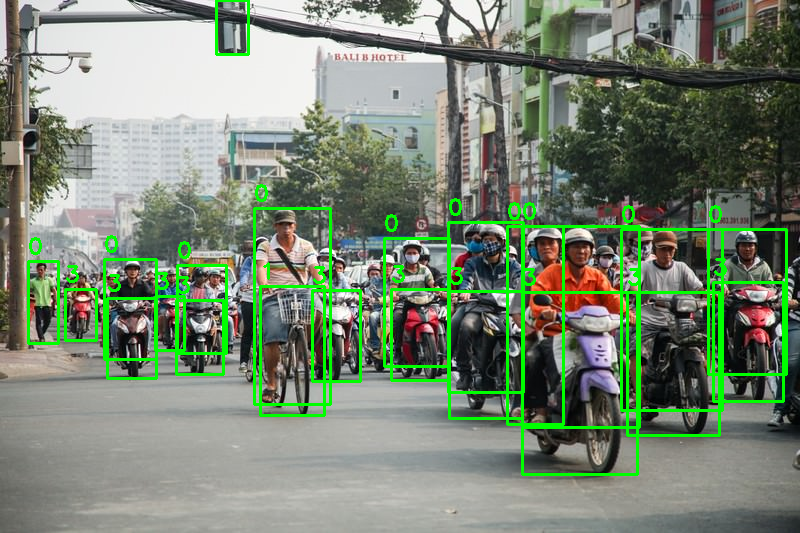

In [14]:
from google.colab.patches import cv2_imshow

cv2_imshow(debug_image)